# Spotify end to end recommendation system project
In this project, I am trying to create a **content base recommendation system** using the data I collect from Spotify. To build this system, I use the data of my favorite songs and the songs between **2017** and **2022**.

# Project Overview :

## 1 - Setup Spotify Api 

## 2 - Collecting Data
- Collect songs between 2017 and 2022
- Collect songs that i liked
- Collect audio features of collected songs 
- Collect audio features of liked songs
- Merge songs and their audio features
- Save data into a csv file

## 3 - Understand the data
- Shape of the data
- Check column dtypes
- Check is there any null values
- Check the correlation

## 4 - Cleaning the data 
- Drop "album genres" column
- Convert artist genres to str

## 5 - Analyzing Data
- Number of songs per year
- Songs duration distribution and (min,avg,max) 
- Song popularity distribution and (min,avg,mode,max)
- Artist genres wordcolud 
- Analyzing audio features

In [1]:
# Collecct data from spotify
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

# Data Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import colors
from  termcolor import cprint
import plotly.express as px
import seaborn as sns
import warnings


# Data Clustring
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Data Preprocessing
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re


%matplotlib inline
warnings.filterwarnings("ignore")

## 1 - Setup Spotify Api 

In [ ]:
# setup api
cid = 'YOUR_CLIENT_ID'
secret = 'YOUR_SECRET_ID'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## 2 - Collecting Data
- Collect songs between 2017 and 2022
- Collect audio features of collected songs 
- Collect songs that i liked
- Collect audio features of liked songs
- Merge songs and their audio features
- Save data into a csv file

### Collect songs between 2017 and 2022

- #####  id : song id  
- #####  song name : name of the songs   
- #####  artist name : name of artist who sing the song
- #####  artist genres : genres that artist sings
- #####  album genres : genres of songs album  
- #####  release_date : release date of song
- #####  song link : link of song on spotify
- #####  image : cover image of song  
- #####  song duration : song duration   
- #####  song popularity : song popularity on spotify


In [ ]:
songs_list = []

years = ['2017','2018','2019','2020','2021','2022']

for year in years : 
    for i in range(0,1000,50):
        track_results = sp.search(q='year:'+year,type='track',limit=50, offset=i)
        for i, t in enumerate(track_results['tracks']['items']):
            artist = sp.artist(t["artists"][0]["external_urls"]["spotify"])
            album = sp.album(t["album"]["external_urls"]["spotify"])
            songs_data = {
                    'id':t['id'],
                    'song name':t['name'],
                    'artist name':t['artists'][0]['name'],
                    'artist genres':artist["genres"],
                    'preview_url': t['preview_url']
                    'album genres': album["genres"],
                    'release_date':t['album']['release_date'],
                    'song link':t['external_urls']['spotify'],
                    'image': t['album']['images'][0]['url'],
                    'song duration':t['duration_ms'],
                    'song popularity' : t['popularity']
                }
            songs_list.append(songs_data)
df_songs = pd.DataFrame(songs_list)

### Collect audio features of collected songs 

- #####  Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- ##### Acousticness: A measure from 0.0 to 1.0 of whether the track is acoustic.
- ##### Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
- ##### Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
- ##### Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- #####  Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.
- #####  Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- #####  Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- ##### Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [ ]:
audio_features = []
for ids in df['id']:
    try : 
        results = sp.audio_features(ids)
        audio_data = {
            'id':ids,
            'danceability':results[0]['danceability'],
            'energy':results[0]['energy'],
            'key':results[0]["key"],
            'loudness': results[0]["loudness"],
            'mode':results[0]['mode'],
            'speechiness':results[0]['speechiness'],
            'acousticness': results[0]['acousticness'],
            'instrumentalness':results[0]['instrumentalness'],
            'liveness':results[0]['liveness'],
            'valence':results[0]['valence'],
            'tempo':results[0]['tempo'],
            'time_signature' : results[0]['time_signature'],
        }
        audio_features.append(audio_data)
    except : 
        print('cant')
        
df_audios  = pd.DataFrame(audio_features)

In [ ]:
# merge audios and songs by id 
df = pd.merge(df_songs, df_audios, on='id')

In [ ]:
# save data into a csv file
df.to_csv('spotify_songs_2017_2022.csv',index=False)

### Collect songs that i liked

In [ ]:
playlist_link = "https://open.spotify.com/playlist/2wQaxhZC3HXtmWd2yjqJG7?si=bc4f208ae2a14ab2"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [ ]:
playlist_songs = []

for t in sp.playlist_tracks(playlist_URI)["items"]:
    try : 
        artist = sp.artist(t['track']["artists"][0]["external_urls"]["spotify"])
        album = sp.album(t['track']["album"]["external_urls"]["spotify"])
        songs_data = {
                'id':t['track']['id'],
                'song name':t['track']['name'],
                'artist name':t['track']['artists'][0]['name'],
                'artist genres':artist["genres"],
                'album genres': album["genres"],
                'release_date':t['track']['album']['release_date'],
                'song link':t['track']['external_urls']['spotify'],
                'image': t['track']['album']['images'][0]['url'],
                'song duration':t['track']['duration_ms'],
                'song popularity' : t['track']['popularity']
        }
        playlist_songs.append(songs_data)
    except :
        print('cant')
df_playlist_songs = pd.DataFrame(playlist_songs)

### Collect audio features of liked songs

In [ ]:
playlist_audio_features = []

for ids in df_playlist_songs['id']:
    try : 
        results = sp.audio_features(ids)
        audio_data = {
            'id':ids,
            'danceability':results[0]['danceability'],
            'energy':results[0]['energy'],
            'key':results[0]["key"],
            'loudness': results[0]["loudness"],
            'mode':results[0]['mode'],
            'speechiness':results[0]['speechiness'],
            'acousticness': results[0]['acousticness'],
            'instrumentalness':results[0]['instrumentalness'],
            'liveness':results[0]['liveness'],
            'valence':results[0]['valence'],
            'tempo':results[0]['tempo'],
            'time_signature' : results[0]['time_signature'],
        }
        playlist_audio_features.append(audio_data)
    except : 
        print('cant')
df_plsylist_audio_fe  = pd.DataFrame(playlist_audio_features)

In [ ]:
# merge playlist datas by id 
df_playlist = pd.merge(df_plsylist_audio_fe, df_playlist_songs, on='id')

In [ ]:
# save playlist data into a csv
df_playlist.to_csv('fav_playlist_songs.csv',index=False)

# Loading the data

In [2]:
# import songs dataset
df_songs = pd.read_csv('spotify_songs_2017_2022_v2.csv')

In [3]:
# import favorite songs playlist dataset playlist dataset
df_playlist = pd.read_csv('fav_playlist_songs.csv')

## 3 - Understanding the data
- Shape of the data
- Check column dtypes
- Check is there any null values
- Describe numerical values
- Check the correlation

### Shape of the data

In [4]:
print("shape of df_songs :",df_songs.shape)
cprint('*'*42,'green')  
print("shape of df_playlist :",df_playlist.shape)

shape of df_songs : (5990, 22)
******************************************
shape of df_playlist : (27, 22)


### Check column dtypes

In [5]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5990 entries, 0 to 5989
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5990 non-null   object 
 1   song name         5990 non-null   object 
 2   artist name       5990 non-null   object 
 3   artist genres     5990 non-null   object 
 4   album genres      5990 non-null   object 
 5   release_date      5990 non-null   object 
 6   song link         5990 non-null   object 
 7   image             5990 non-null   object 
 8   song duration     5990 non-null   int64  
 9   song popularity   5990 non-null   int64  
 10  danceability      5990 non-null   float64
 11  energy            5990 non-null   float64
 12  key               5990 non-null   int64  
 13  loudness          5990 non-null   float64
 14  mode              5990 non-null   int64  
 15  speechiness       5990 non-null   float64
 16  acousticness      5990 non-null   float64


### Check is there any null values

In [6]:
df_songs.isnull().sum()

id                  0
song name           0
artist name         0
artist genres       0
album genres        0
release_date        0
song link           0
image               0
song duration       0
song popularity     0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

In [7]:
df_playlist.isnull().sum()

id                  0
song name           0
artist name         0
artist genres       0
album genres        0
release_date        0
song link           0
image               0
song duration       0
song popularity     0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

### Describe numerical values

In [8]:
df_songs.describe()

,song duration,song popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000
mean,197364.741068,68.752421,0.656187,0.602360,5.172621,-7.136661,0.638731,0.117713,0.267350,0.036734,0.173900,0.471723,122.113027,3.920367
std,51485.330619,14.869443,0.156715,0.187765,3.584430,3.661431,0.480408,0.116276,0.274327,0.153085,0.130967,0.228822,29.969551,0.394277
min,39591.000000,0.000000,0.000000,0.000020,0.000000,-40.449000,0.000000,0.000000,0.000000,0.000000,0.021500,0.000000,0.000000,0.000000
25%,166483.500000,66.000000,0.559000,0.483000,2.000000,-8.312250,0.000000,0.038600,0.042200,0.000000,0.099000,0.293000,97.985000,4.000000
50%,195113.000000,70.000000,0.670000,0.619000,5.000000,-6.421000,1.000000,0.062400,0.162000,0.000000,0.120000,0.463000,121.927000,4.000000
75%,222981.000000,75.000000,0.771000,0.736000,8.000000,-5.041000,1.000000,0.156000,0.427750,0.000103,0.203000,0.642000,142.664750,4.000000
max,646239.000000,100.000000,0.980000,1.000000,11.000000,1.060000,1.000000,0.868000,0.996000,1.000000,0.967000,0.980000,220.099000,5.000000


### Correlation between variables

<AxesSubplot:>

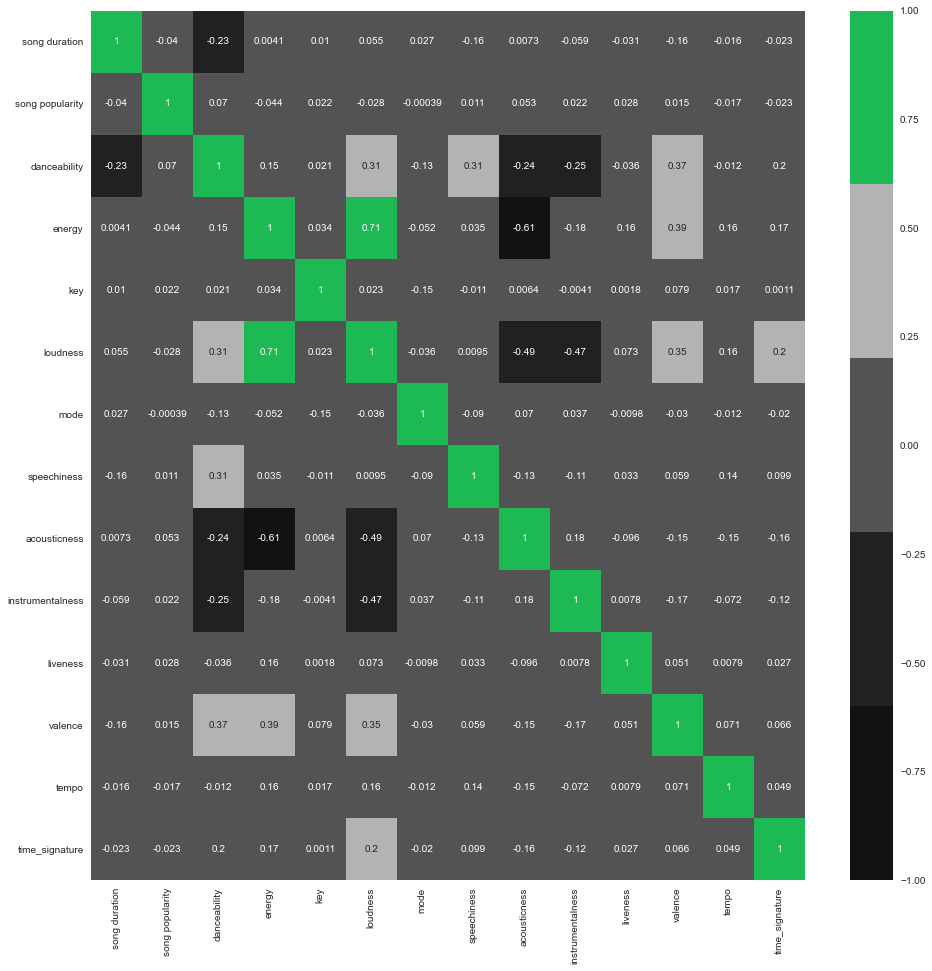

In [9]:
cmap = colors.ListedColormap([ "#131212","#212121", "#535353","#b3b3b3","#1db954"])
corr= df_songs.corr()
plt.figure(figsize=(16,16))  
sns.heatmap(corr,annot=True, cmap=cmap,vmax=1,vmin=-1)

## 4 - Cleaning the data
- Drop album genres	column
- Drop duplicated songs
- Convert artist genres to str

### Drop album genres column

In [10]:
df_songs['album genres'].value_counts()

[]    5990
Name: album genres, dtype: int64

In [11]:
df_playlist['album genres'].value_counts()

[]    27
Name: album genres, dtype: int64

In [12]:
df_songs    =  df_songs.drop('album genres',axis=1)
df_playlist =  df_playlist.drop('album genres',axis=1)

### Drop duplicated songs

In [13]:
df_songs = df_songs.drop_duplicates(['song name','artist name'],keep='first')

### Convert artist genres to str

In [14]:
df_songs['artist genres'] = df_songs['artist genres'].apply(lambda x : re.sub(r"'", r'',x[2:-1]))

## 5 - Analyzing Data
- Number of songs per year
- Songs duration distribution and (min,avg,max) 
- Song popularity distribution and (min,avg,mode,max)
- Artist genres wordcolud 

## Number of songs per year

Number of songs per year :
2017    992
2018    975
2019    969
2020    943
2021    921
2022    795
Name: release_date, dtype: int64
**************************************************


Text(0.5, 1.0, 'Number of songs per year')

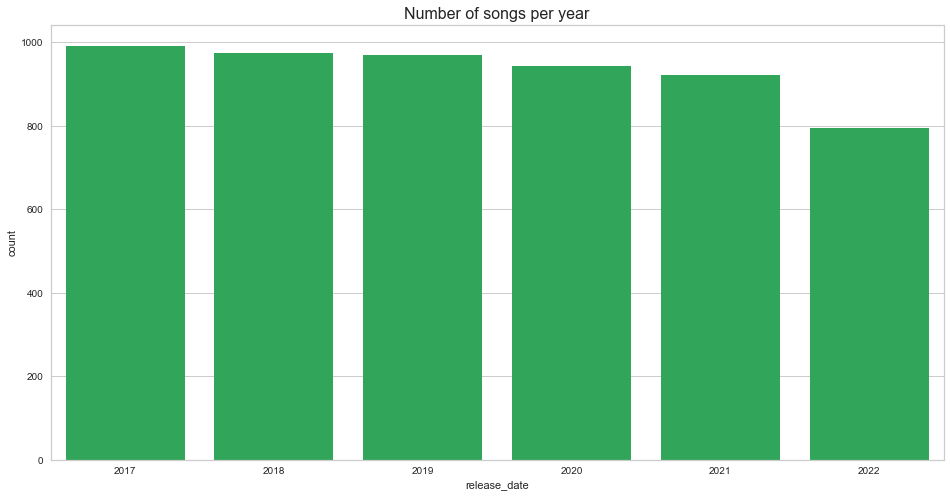

In [15]:
cprint('Number of songs per year :','green')
print(df_songs['release_date'].apply(lambda x :x.split('-')[0]).value_counts())
cprint('*'*50,'green')
plt.rcParams['figure.figsize'] = (16, 8)
songsyear=sns.countplot(x=df_songs['release_date'].apply(lambda x :x.split('-')[0]),palette=["#1db954"])
songsyear.set_title('Number of songs per year',fontsize=16)

Number of songs per year :
2021    5
2017    5
2002    2
2018    2
2019    2
1999    2
2015    1
2003    1
1968    1
2004    1
2001    1
2016    1
2020    1
2022    1
2000    1
Name: release_date, dtype: int64
**************************************************


Text(0.5, 1.0, 'Number of songs per year')

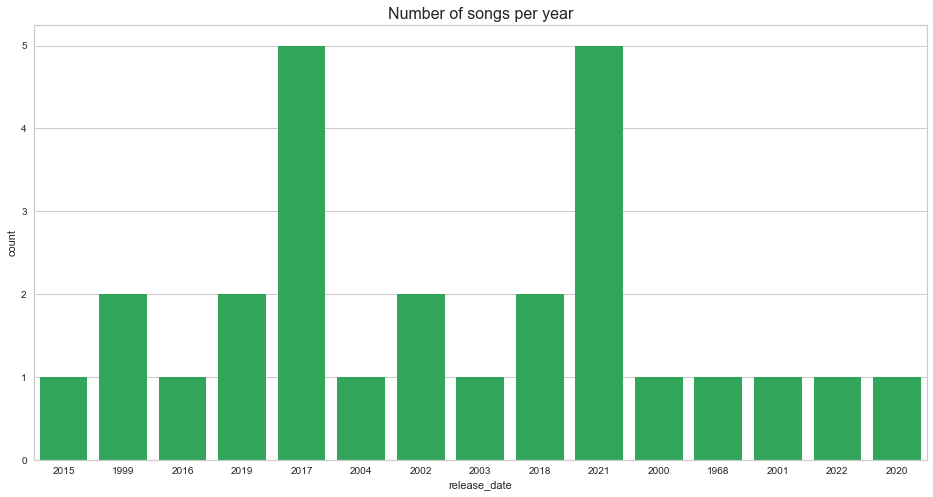

In [16]:
cprint('Number of songs per year :','green')
print(df_playlist['release_date'].apply(lambda x :x.split('-')[0]).value_counts())
cprint('*'*50,'green')
plt.rcParams['figure.figsize'] = (16, 8)
songsyear=sns.countplot(x=df_playlist['release_date'].apply(lambda x :x.split('-')[0]),palette=["#1db954"])
songsyear.set_title('Number of songs per year',fontsize=16)

### Songs duration distribution and (min,avg,max) 

min and avg and max song duration :
count        27.000000
mean     213864.037037
std       47512.306808
min      146005.000000
25%      172053.500000
50%      203133.000000
75%      258813.000000
max      290320.000000
Name: song duration, dtype: float64
**************************************************


<AxesSubplot:xlabel='song duration', ylabel='Count'>

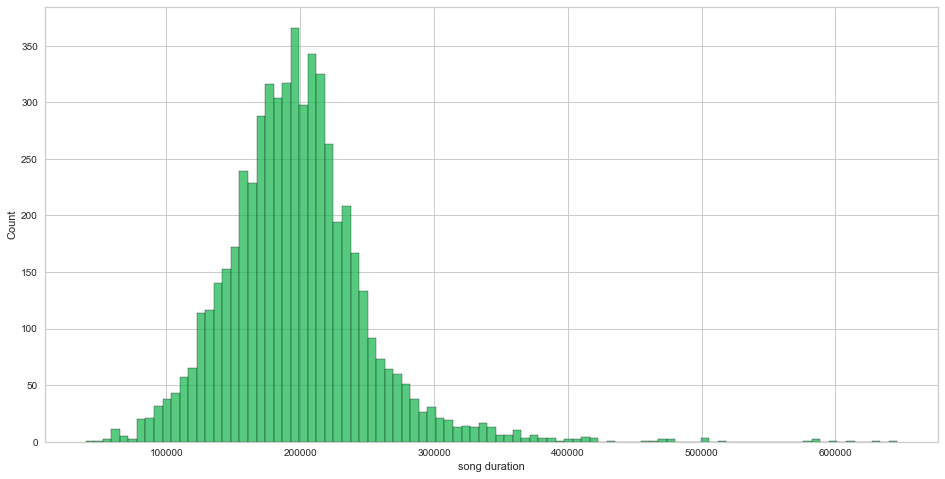

In [17]:
cprint('min and avg and max song duration :','green')
print(df_playlist['song duration'].describe())
cprint('*'*50,'green')
sns.histplot(x=df_songs['song duration'],color="#1db954")

<AxesSubplot:xlabel='song duration', ylabel='Count'>

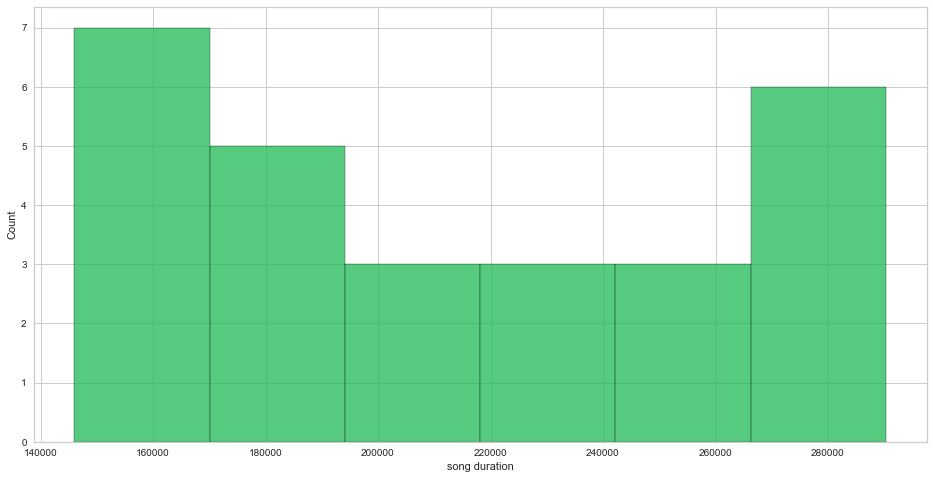

In [18]:
sns.histplot(x=df_playlist['song duration'],color="#1db954")

### Song popularity distribution and (min,avg,mode,max)

67     362
72     327
70     327
69     321
71     317
68     308
65     294
66     282
64     272
74     269
73     257
75     246
63     231
76     204
77     200
79     168
62     148
78     143
80     129
81     109
61      90
83      76
82      75
84      68
0       65
60      61
85      42
86      33
87      29
89      26
59      25
88      18
90      14
91      12
58       9
93       6
98       4
57       4
96       4
92       4
56       4
2        3
95       3
97       2
94       1
48       1
1        1
100      1
Name: song popularity, dtype: int64
**************************************************
count    5595.000000
mean       70.442002
std        10.256419
min         0.000000
25%        66.000000
50%        70.000000
75%        75.000000
max       100.000000
Name: song popularity, dtype: float64
**************************************************
most frequently value : 
0    67
dtype: int64
**************************************************


<AxesSubplot:xlabel='song popularity', ylabel='count'>

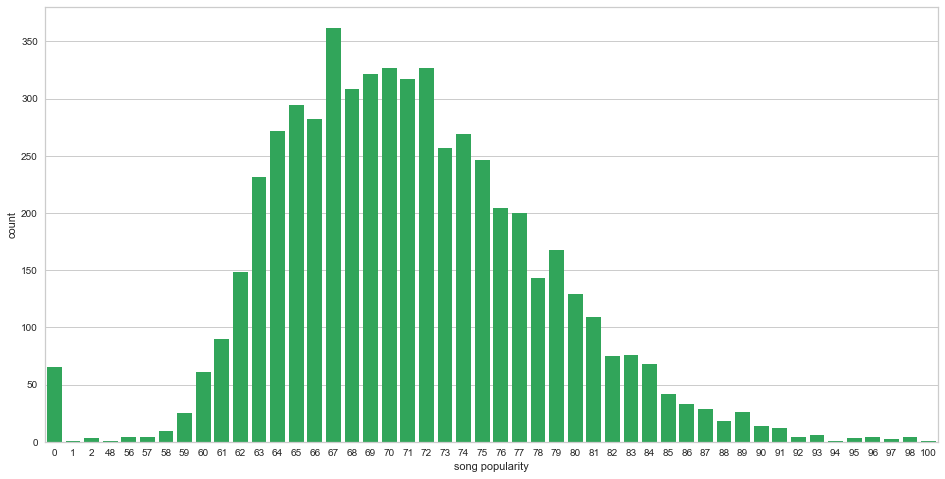

In [19]:
print(df_songs['song popularity'].value_counts())

cprint('*'*50,'green')

print(df_songs['song popularity'].describe())

cprint('*'*50,'green')

print('most frequently value : ')

print(df_songs['song popularity'].mode())

cprint('*'*50,'green')

sns.countplot(x=df_songs['song popularity'],color="#1db954")

58    3
0     2
89    2
75    2
71    2
79    1
77    1
88    1
67    1
84    1
81    1
45    1
78    1
65    1
74    1
39    1
37    1
4     1
64    1
66    1
63    1
Name: song popularity, dtype: int64
**************************************************
count    27.000000
mean     61.296296
std      25.553586
min       0.000000
25%      58.000000
50%      67.000000
75%      77.500000
max      89.000000
Name: song popularity, dtype: float64
**************************************************
most frequently value : 
0    58
dtype: int64
**************************************************


<AxesSubplot:xlabel='song popularity', ylabel='count'>

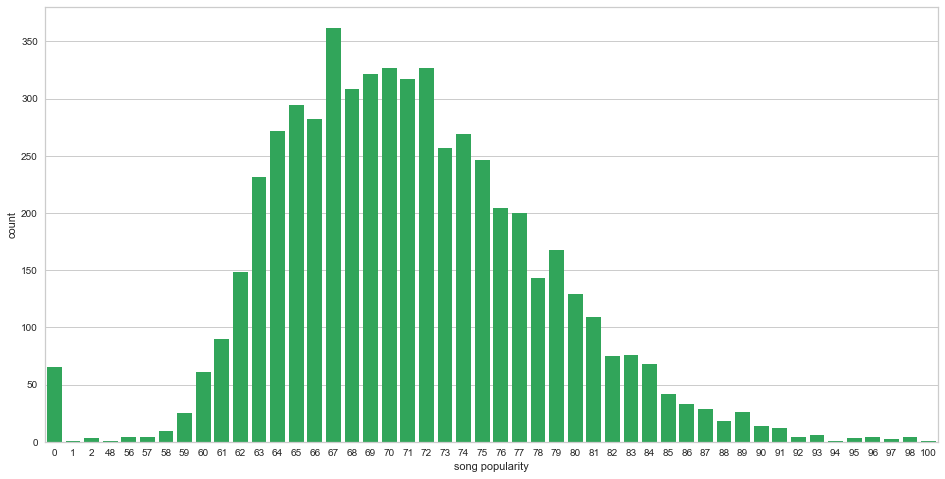

In [20]:
print(df_playlist['song popularity'].value_counts())

cprint('*'*50,'green')

print(df_playlist['song popularity'].describe())

cprint('*'*50,'green')

print('most frequently value : ')

print(df_playlist['song popularity'].mode())

cprint('*'*50,'green')
sns.countplot(x=df_songs['song popularity'],color="#1db954")

### Artist genres wordcolud

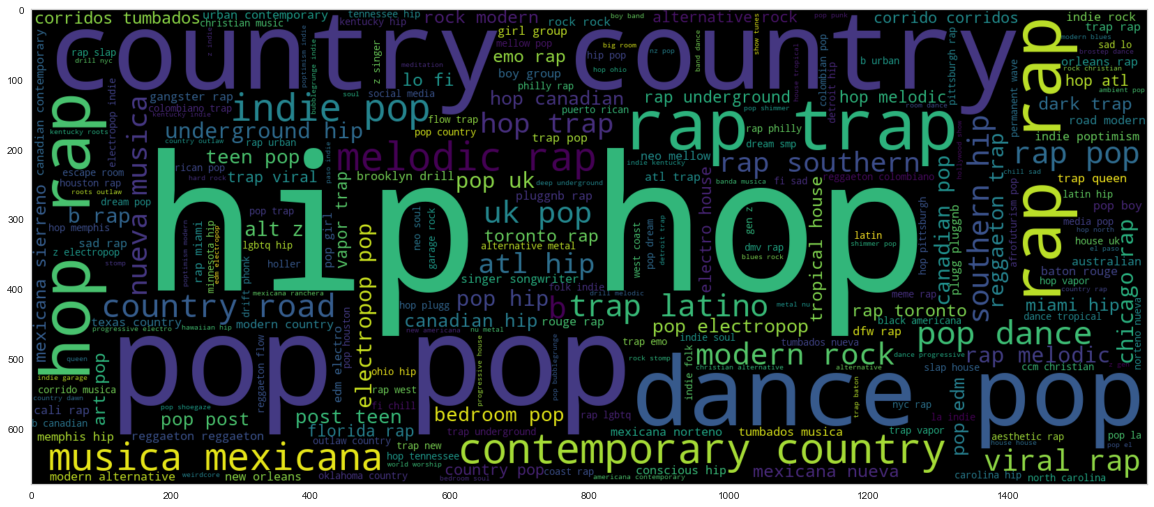

In [26]:
plt.figure(figsize = (20,20)) 
worldcould_bad = WordCloud(min_font_size = 3,  max_words = 250 , width = 1600 , height = 680).generate(" ".join(df_songs['artist genres']))
plt.imshow(worldcould_bad,interpolation = 'bilinear')
plt.grid(None)

### Analyzing audio features

<AxesSubplot:xlabel='key', ylabel='song popularity'>

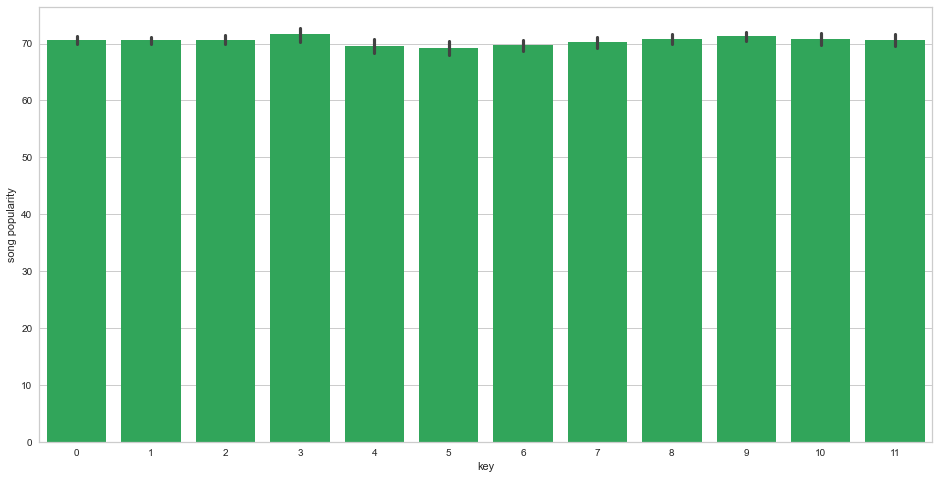

In [27]:
sns.barplot(x=df_songs['key'],y=df_songs['song popularity'],color="#1db954")

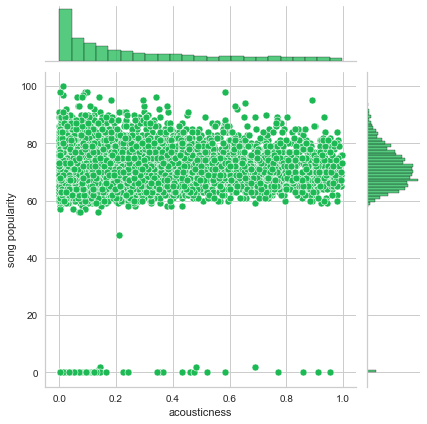

In [28]:
sns.jointplot(x=df_songs['acousticness'],y=df_songs['song popularity'],color="#1db954")

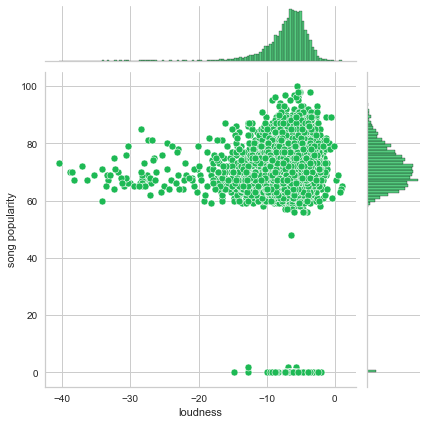

In [29]:
sns.jointplot(x=df_songs['loudness'],y=df_songs['song popularity'],color="#1db954")

## 6 - Apply Dmensionality Reduction¶
- Split audio features from data 
- Standard Scaling Audio Features
- Apply PCA
- Put PCA Output Into a Dataframe
- Visualize reduced dimension Data

### Split audio features from data 

In [22]:
df_audios = df_songs[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]  

### Standard Scaling Audio Features

In [23]:
std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(df_audios)

In [24]:
scaled_df = pd.DataFrame(std_data,columns= df_audios.columns)

### Apply PCA

In [25]:
## Apply PCA on scaled data
pca = PCA(3,svd_solver='full')
pca.fit(scaled_df)
lowdim_df = pca.transform(scaled_df)

### Put PCA Output Into a Dataframe

In [26]:
# Put PCA output into a dataframe
columns = ['pca_comp_%i' % i for i in range(3)]
df_pca  = pd.DataFrame(lowdim_df, columns=columns, index=scaled_df.index)
df_pca.head()

,pca_comp_0,pca_comp_1,pca_comp_2
0,-1.125071,-0.780359,-0.181450
1,2.350225,-1.886966,0.373857
2,0.770998,-0.082000,-0.086816
3,-1.949422,0.642207,1.291232
4,2.623664,3.014541,1.112183


### Visualize reduced dimension Data

In [27]:
# Visualize reduced dimension data in a 3d way
fig = px.scatter_3d(df_pca, x='pca_comp_0', y='pca_comp_1', z='pca_comp_2',size_max=20 ,color_discrete_sequence=['#1db954'],
title="PCA Output Visualization")
fig.update_traces(marker=dict(size=8,line=dict(width=2,color='#121212')),selector=dict(mode='markers'))
fig.update_layout(autosize=False,
    width=700,
    height=680,)
fig.show()

## 7 - Apply Clustering¶
- Select the right value of k for clustring
- Fit reduced dimension data into Kmeans
- Visualize clusterd data (kemans output)

### Select the right value of k for clustring

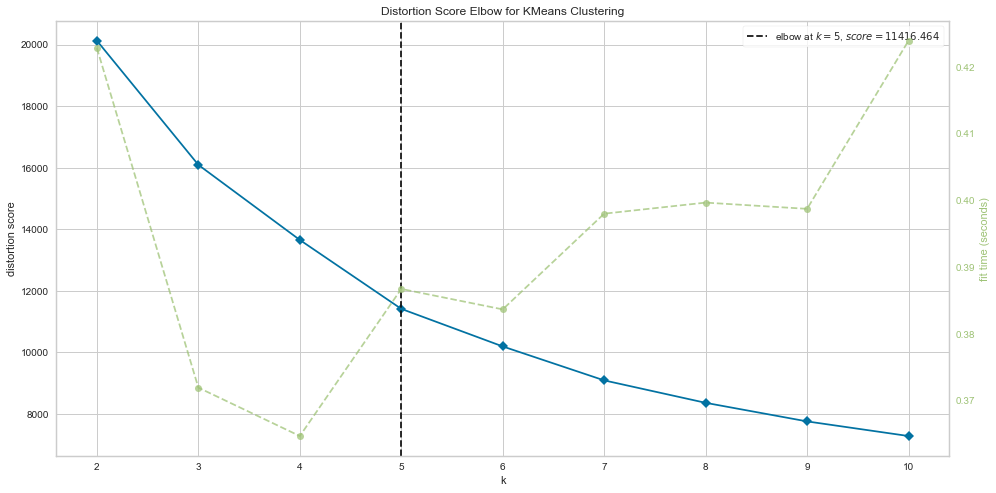

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_pca)
Elbow_M.show()

### Fit reduced dimension data into Kmeans

In [37]:
KM = KMeans(n_clusters=5)
km_pred = KM.fit_predict(df_pca)

In [38]:
df_songs["cluster"]= km_pred

In [39]:
df_pca["cluster"] = km_pred

### Visualize clusterd data (kemans output)

In [40]:
# Visualize clusterd reduced dimension data in a 3d way
fig = px.scatter_3d(df_pca, x='pca_comp_0', y='pca_comp_1', z='pca_comp_2',
title="Clusters Visualization",color="cluster")
fig.update_traces(marker=dict(size=4),selector=dict(mode='markers'))
fig.update_layout(autosize=False,
    width=700,
    height=680,)
fig.show()